**Задание**

Пока на нашем графике результата видно, что модель классифицирует яблоки и груши не очень хорошо, включая в яблоки довольно много груш. Этот момент надо исправить.
    
1) Часто вместо алгоритма оптимизации **SGD** применяется более продвинутый алгоритм **Adam**. Найдите в документации по PyTorch этот алгоритм и используйте его вместо SGD. Он работает значительно эффективнее: уже после 1000 эпох лосс составит около 0.015.

А может быть, вам получится сделать и ещё более эффективное решение? Попробуйте поэкспериментировать например с разными функциями активации (посмотрите ноутбук из пункта 6 занятия DLSchool по последней ссылке).

2) Постройте график зависимости лосса от количества эпох.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import optim, nn
from torch.nn import Linear, Sigmoid

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step


def plot_learning_curve(loss_array: list):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(loss_array)), loss_array)
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## 0. Configs

In [3]:
# Configs
LR = 0.1
N_EPOCHS = 10000
URL_DATASET_PATH = "https://skillsmart.ru/data/apples_pears.csv"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

np.random.seed(42)
torch.manual_seed(42)

## 1. Чтение исходных данных

In [4]:
data = pd.read_csv(URL_DATASET_PATH)
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


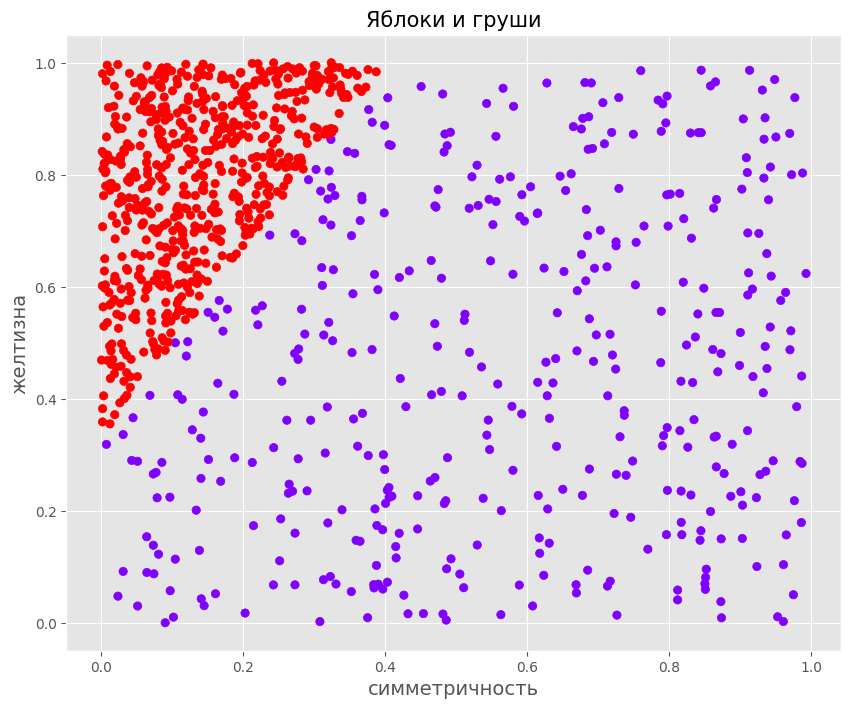

In [5]:
plt.figure(figsize=(10, 8)) # пропорции графика
plt.scatter(data.iloc[:, 1], data.iloc[:, 0], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()

## 2. Предобработка данных

In [6]:
X = torch.FloatTensor(data.iloc[:,:2].values)
y = torch.FloatTensor(data['target'].values.reshape((-1, 1))) # сжимаем до одного измерения

## 3. Обучение модели

In [50]:
layers_sequentials = {
    "default": (Linear(2, out_features=1), Sigmoid()),
    "seq_1": (Linear(2, out_features=1), nn.Tanh()),
    "seq_2": (Linear(2, out_features=1), nn.Tanh(), Sigmoid()),
    "seq_3": (Linear(2, out_features=1), nn.LogSigmoid(), Sigmoid()),
}

epoch_losses = {}
for seq_name, sequential in layers_sequentials.items():
    # Prepare model params
    neuron = torch.nn.Sequential(*sequential)
    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(neuron.parameters(), lr=LR)
    train_step = make_train_step(neuron, loss_fn, optimizer)
    # Fit model
    epoch_loss = []
    for epoch in range(N_EPOCHS):
        loss = train_step(X, y)
        epoch_loss.append(loss)
    epoch_losses[seq_name] = epoch_loss

default


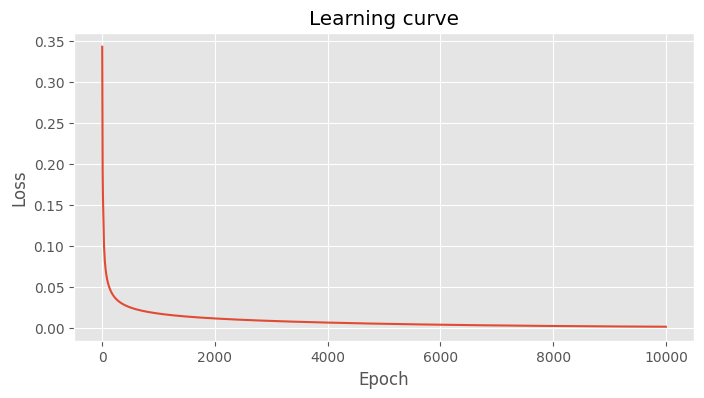

Best loss: 0.0016971842851489782

seq_1


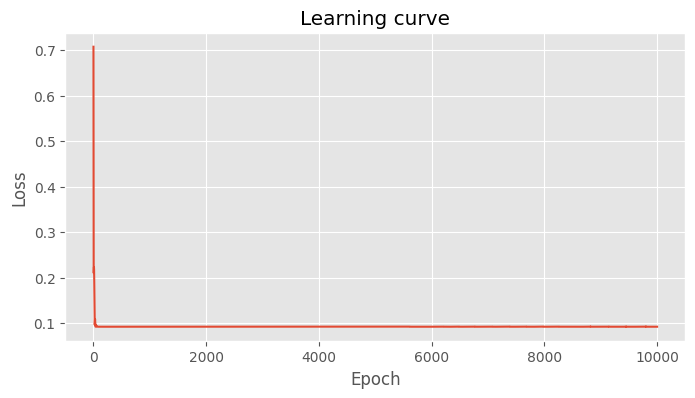

Best loss: 0.0917755588889122

seq_2


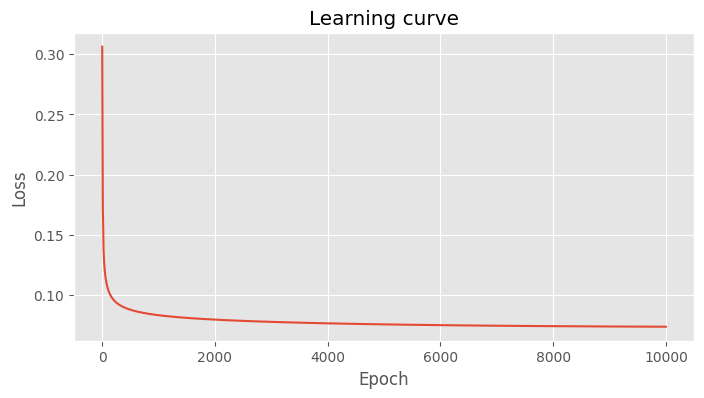

Best loss: 0.07336238771677017

seq_3


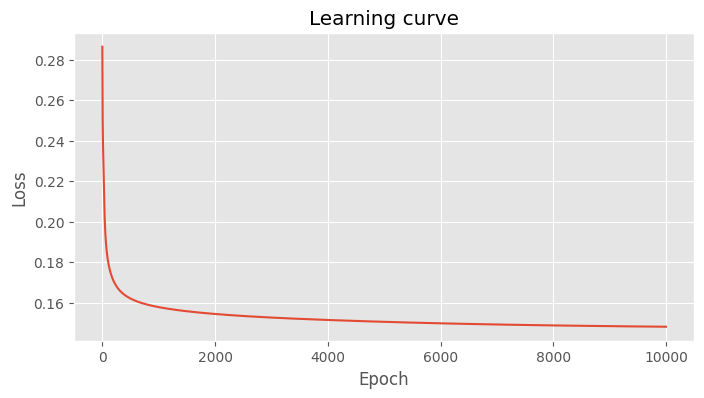

Best loss: 0.14805163443088531



In [51]:
for seq_name, loss_array in epoch_losses.items():
    # Построим график зависимости лосса от количества эпох.
    print(seq_name)
    plot_learning_curve(loss_array)
    print(f"Best loss:", min(loss_array))
    print()

## 4. Прогноз для лучшей модели

Лучшей моделью по итогам обучения оказалась исходная архитектура модели с оптимизатором Adam.

Значение лучшей ошибки ~ 0.0017176468390971422 для 10000 эпох.

К сожалению, эксперименты с изменениями функции активации и добавлением дополнительных слоёв не принесли роста качества модели (выше оставил только наиболее успешные сочетания, что мне удалось найти).

Дальнейший рост качества модели (незначительный), на мой взгляд, можно попробовать обеспечить благодаря:

1. Увеличению кол-ва эпох
2. Снижению learning rate

In [57]:
# Fit best model
neuron = torch.nn.Sequential(
    Linear(2, out_features=1),
    Sigmoid()
)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(neuron.parameters(), lr=LR)
train_step = make_train_step(neuron, loss_fn, optimizer)
# Fit model
for epoch in range(N_EPOCHS):
    loss = train_step(X, y)

print("Best model loss:", loss)

Best model loss: 0.0017176468390971422


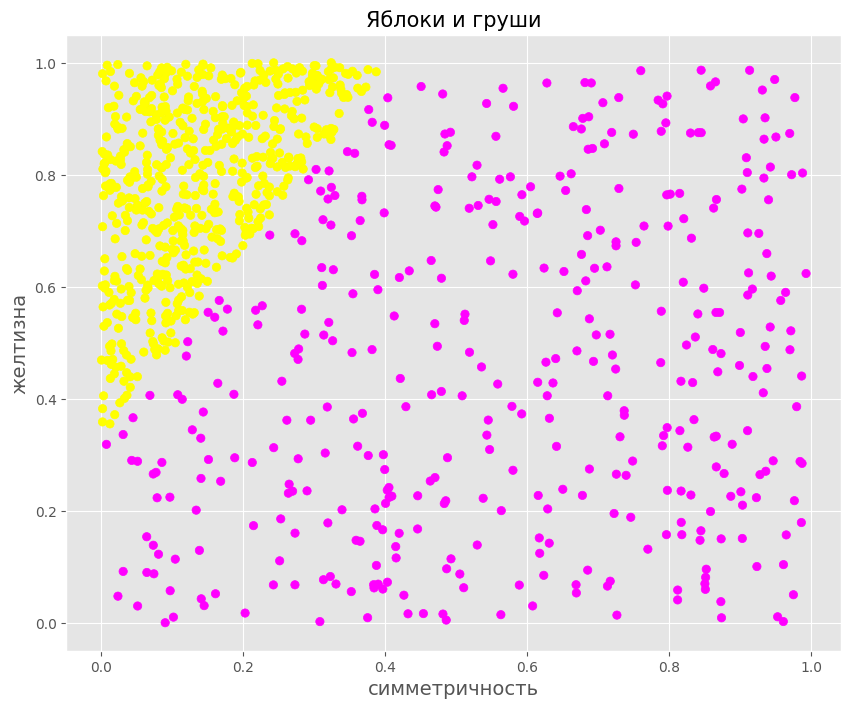

In [58]:
# Визуализация прогноза для лучшей модели
neuro_data = neuron(X)
y2 = neuro_data > 0.5
y2 = y2.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 1], data.iloc[:, 0], c=y2, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()